<font size=20>**Using SHAP Values for Model Interpretability**<font>

In [1]:
#!pip install shap
#!pip install shap
#! pip install dice-ml


# Imports

In [109]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

import dice_ml

import pickle
import shap
shap.initjs()


# Loading Data

In [119]:
df = pd.read_csv('../processed_data/cleaned_data_final.csv')
df.head(5)


,name,male,origin,isMarried,isNoble,popularity,isAlive,season,episode,deaths,episode_num
0,Viserys II Targaryen,1,House Targaryen,0,0,0.605351,0,8,The Bells,Lord Varys - Burned alive by Drogon with his f...,71
1,Walder Frey,1,House Frey,1,1,0.896321,0,6,The Winds of Winter,Lord Walder Frey - Throat slit by Arya Stark w...,60
2,Addison Hill,1,House Lannister,0,1,0.267559,1,0,NaN,NaN,0
3,Aemma Arryn,0,House Arryn,1,1,0.183946,0,5,The Gift,Maester Aemon Targaryen - Died of natural causes.,47
4,Sylva Santagar,0,House Martell,1,1,0.043478,1,0,NaN,NaN,0


## Setting X and y

In [120]:
X = df
X = X.drop(columns = ["name",'isAlive','episode','deaths','season',
       'episode_num'], axis=1)


y = df[["isAlive"]]

print(f'Features: {X.columns},\n \ny.head(5):\n{y.head()}')


Features: Index(['male', 'origin', 'isMarried', 'isNoble', 'popularity'], dtype='object'),
 
y.head(5):
   isAlive
0        0
1        0
2        1
3        0
4        1


# Loading model from pickle file

In [121]:
model_xgb = pickle.load(open( "../got_survival/models_pickle/death_model.pkl", "rb"))


In [122]:
model_xgb


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  Pipeline(steps=[('standar_scaler',
                                                                   StandardScaler())]),
                                                  ['popularity']),
                                                 ('cat_transformer',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['origin']),
                                                 ('passthrough', 'passthrough',
                                                  ['isMarried', 'isNoble',
                                                   'male'])])),
                ('xgbclassifier',
                 XGBClassifier(base_sc...
                               feature_types=None, gamma=0.558,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.024, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=4,
                               max_leaves=None, min_child_weight=6, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [7]:
model_xgb.__dict__


{'steps': [('columntransformer',
   ColumnTransformer(transformers=[('num_transformer',
                                    Pipeline(steps=[('standar_scaler',
                                                     StandardScaler())]),
                                    ['popularity']),
                                   ('cat_transformer',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse_output=False),
                                    ['origin']),
                                   ('passthrough', 'passthrough',
                                    ['isMarried', 'isNoble', 'male'])])),
  ('xgbclassifier',
   XGBClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, device=None, early_stopping_rounds=None,
                 enable_categorical=False, eval_metric='logloss',
                 feature_typ

In [123]:
X_processed = model_xgb["columntransformer"].transform(X)


In [124]:
model_xgb["xgbclassifier"].predict(X_processed)


array([0, 0, 0, ..., 1, 1, 0])

In [125]:
X_processed.shape


(1949, 24)

In [126]:
shap.initjs()

# Calculate SHAP values
X100 = shap.utils.sample(X_processed, 1949) #Before 200
explainer = shap.TreeExplainer(model_xgb["xgbclassifier"],X100)
shap_values = explainer(X_processed)


[23:26:39] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [133]:
test = pd.DataFrame(X_processed)
#test.columns = [x.split("__")[1] for x in model_xgb["columntransformer"].get_feature_names_out()]

test.columns = ['Popularity', 'Dothraki', 'Foreign Noble',
       'Foreign Peasant', 'House Arryn',
       'House Baratheon', 'House Bolton', 'House Frey',
       'House Greyjoy', 'House Lannister', 'House Martell',
       'House Stark', 'House Targaryen',
       'House Tully', 'House Tyrell', "Night's Watch",'Westerosi Noble',
       'Outlaw', 'Peasant', 'Soldier',
       'Wildling', 'Married', 'Noble', 'Male']


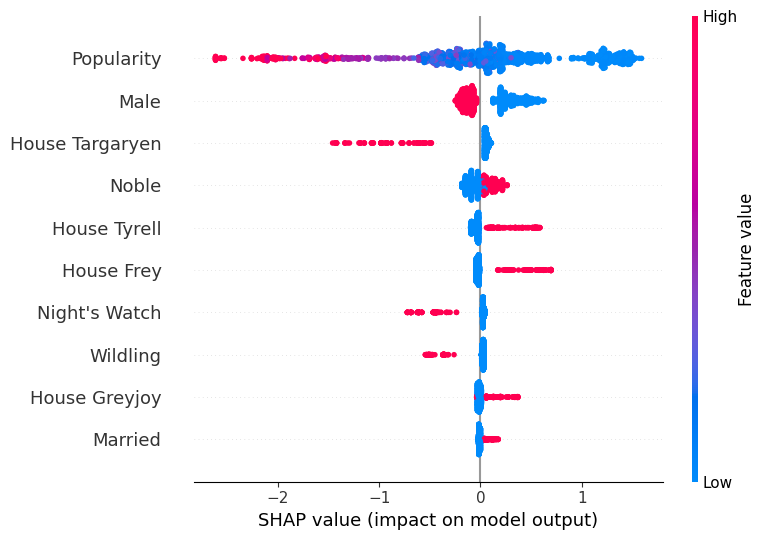

In [134]:

shap.summary_plot(shap_values, test, max_display=10)


## Trying to change the order of the features...

In [135]:
order = [
    "Popularity",
    "Male",
    "House Targaryen",
    "Night's Watch",
    "Wildling",
    "Noble",
    "House Tyrell",
    "House Frey",
    "House Greyjoy",
    "Married"
]


In [136]:
col2num = {col: i for i, col in enumerate(test.columns)}

order = list(map(col2num.get, order))


In [137]:

shap.plots.beeswarm(shap_values, max_display=10, show=False, color_bar=False, order=order)
plt.colorbar()
plt.show()


IndexError: list index out of range

In [139]:
order = [
    "Popularity",
    "Male",
    "House Targaryen",
    "Night's Watch",
    "Wildling",
    "Noble",
    "House Tyrell",
    "House Frey",
    "House Greyjoy",
    "Married"
    ]

col2num = {col: i for i, col in enumerate(test.columns)}

print("Column to Number Mapping:", col2num)

order = [col2num.get(col) for col in order if col in col2num]

print("Order Indices:", order)

shap.plots.beeswarm(shap_values, max_display=10, show=False, color_bar=False, order=order)
plt.colorbar()
plt.show()


Column to Number Mapping: {'Popularity': 0, 'Dothraki': 1, 'Foreign Noble': 2, 'Foreign Peasant': 3, 'House Arryn': 4, 'House Baratheon': 5, 'House Bolton': 6, 'House Frey': 7, 'House Greyjoy': 8, 'House Lannister': 9, 'House Martell': 10, 'House Stark': 11, 'House Targaryen': 12, 'House Tully': 13, 'House Tyrell': 14, "Night's Watch": 15, 'Westerosi Noble': 16, 'Outlaw': 17, 'Peasant': 18, 'Soldier': 19, 'Wildling': 20, 'Married': 21, 'Noble': 22, 'Male': 23}
Order Indices: [0, 23, 12, 15, 20, 22, 14, 7, 8, 21]


IndexError: list index out of range

Shape of shap_values: (1949, 24)
Order Indices: [0, 23, 12, 15, 20, 22, 14, 7, 8, 21]
Features in DataFrame: Index(['Popularity', 'Dothraki', 'Foreign Noble', 'Foreign Peasant',
       'House Arryn', 'House Baratheon', 'House Bolton', 'House Frey',
       'House Greyjoy', 'House Lannister', 'House Martell', 'House Stark',
       'House Targaryen', 'House Tully', 'House Tyrell', 'Night's Watch',
       'Westerosi Noble', 'Outlaw', 'Peasant', 'Soldier', 'Wildling',
       'Married', 'Noble', 'Male'],
      dtype='object')


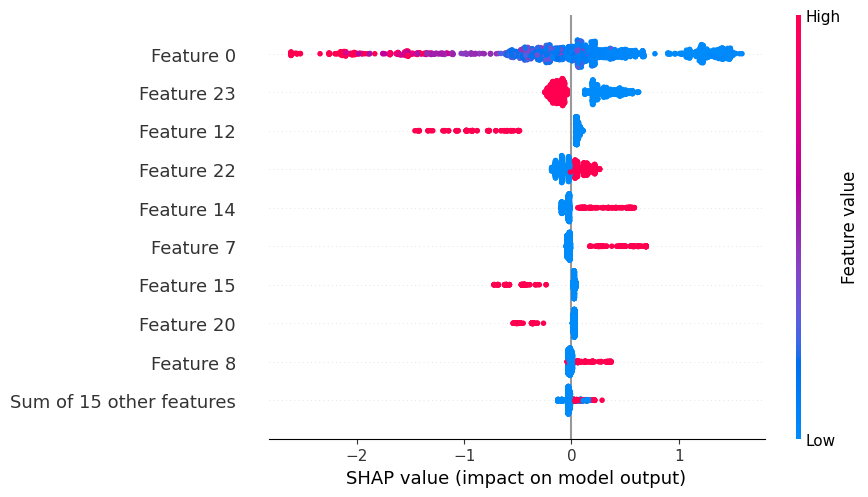

In [140]:
print("Shape of shap_values:", shap_values.shape)
print("Order Indices:", order)
print("Features in DataFrame:", test.columns)

# Run beeswarm plot with default ordering
shap.plots.beeswarm(shap_values, max_display=10)
plt.show()


In [143]:
print("Shape of shap_values:", shap_values.shape)
print("Features in shap_values:", len(shap_values[0]))
print("Features in DataFrame:", test.columns)


Shape of shap_values: (1949, 24)
Features in shap_values: 24
Features in DataFrame: Index(['Popularity', 'Dothraki', 'Foreign Noble', 'Foreign Peasant',
       'House Arryn', 'House Baratheon', 'House Bolton', 'House Frey',
       'House Greyjoy', 'House Lannister', 'House Martell', 'House Stark',
       'House Targaryen', 'House Tully', 'House Tyrell', 'Night's Watch',
       'Westerosi Noble', 'Outlaw', 'Peasant', 'Soldier', 'Wildling',
       'Married', 'Noble', 'Male'],
      dtype='object')


In [144]:
def custom_order(shap_values):
    custom_order_names = [
        "Popularity",
        "Male",
        "House Targaryen",
        "Night's Watch",
        "Wildling",
        "Noble",
        "House Tyrell",
        "House Frey",
        "House Greyjoy",
        "Married"
    ]
    feature_indices = {name: i for i, name in enumerate(test.columns)}
    return [feature_indices[name] for name in custom_order_names if name in feature_indices]

order_indices = custom_order(shap_values)
print("Order Indices:", order_indices)


Order Indices: [0, 23, 12, 15, 20, 22, 14, 7, 8, 21]


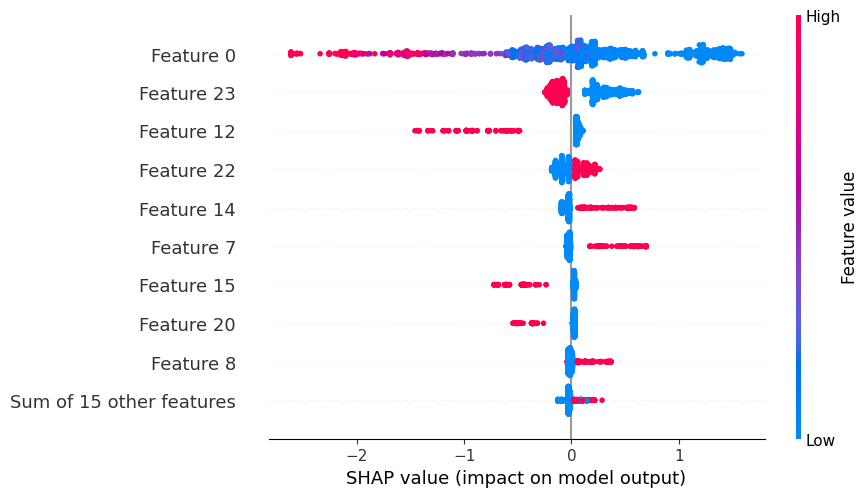

IndexError: list index out of range

In [146]:
# Test with a default order
shap.plots.beeswarm(shap_values, max_display=10)
plt.show()

# Test with a few features
shap.plots.beeswarm(shap_values, max_display=3, order=[0, 1, 2])  # Example indices
plt.show()


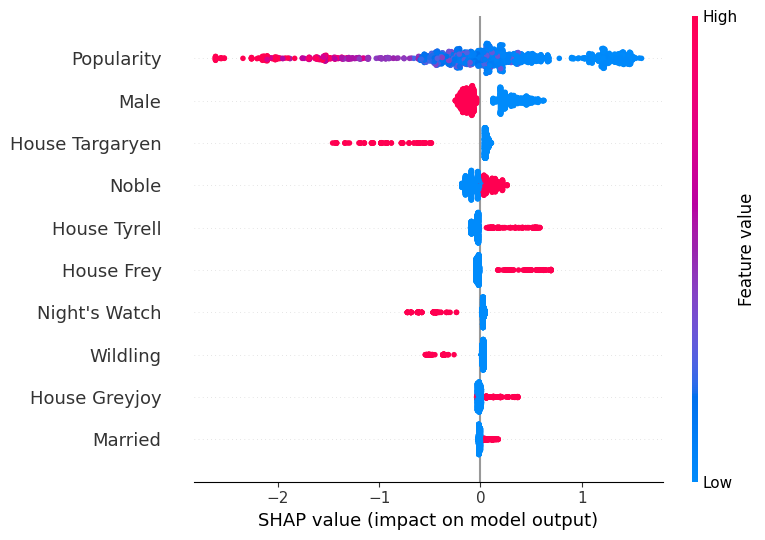

In [148]:
# Desired order of features
feature_order = ["Popularity", "Male", "House Targaryen", "Night's Watch", "Wildling", "Noble", "House Tyrell", "House Frey", "House Greyjoy", "Married"]

# Mapping of feature names to indices
feature_indices = {name: i for i, name in enumerate(test.columns)}

# Reordered SHAP values
ordered_shap_values = shap_values[:, [feature_indices[feature] for feature in feature_order if feature in feature_indices]]

# Plotting
shap.summary_plot(ordered_shap_values, features=test[feature_order], feature_names=feature_order)


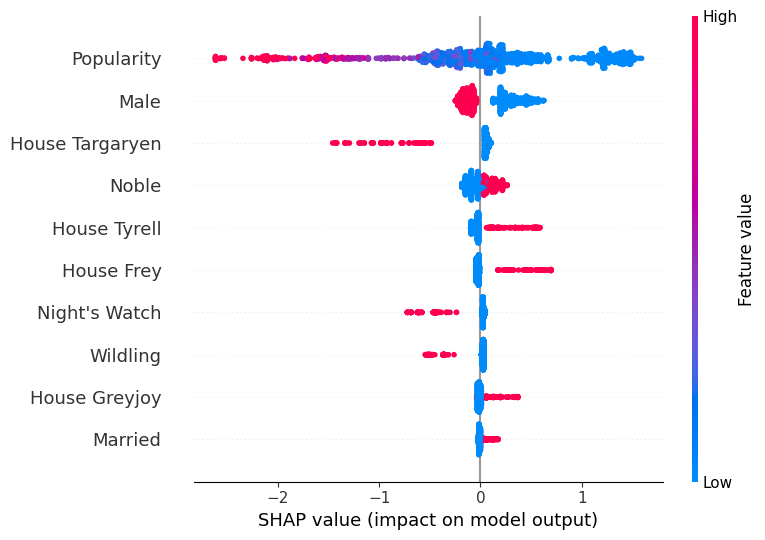

In [149]:

# Desired order of features
feature_order = ["Popularity", "Male", "House Targaryen", "Night's Watch", "Wildling", "Noble", "House Tyrell", "House Frey", "House Greyjoy", "Married"]

# Filter and reorder the DataFrame based on the feature order
filtered_df = test[feature_order]

# Reorder SHAP values according to the feature order
ordered_shap_values = shap_values[:, [test.columns.get_loc(col) for col in feature_order]]

# Plot using summary_plot
shap.summary_plot(ordered_shap_values, filtered_df)


### End of changing the order of the features

In [13]:
shap_values_array = np.array([ex.values for ex in shap_values])


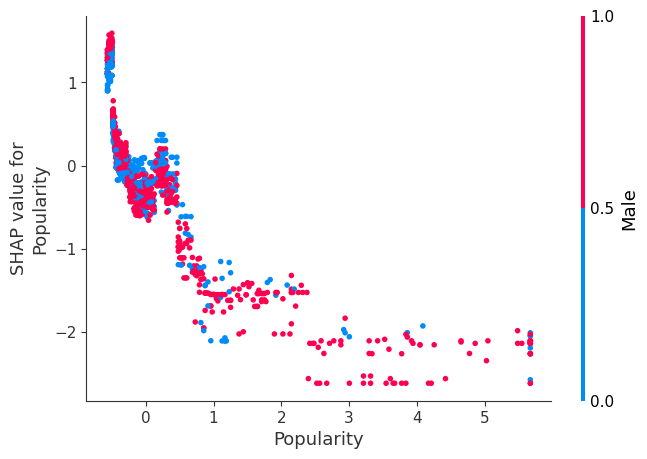

In [14]:
shap.dependence_plot("Popularity", shap_values_array, test,interaction_index="Male")


In [15]:
explainer.expected_value


0.9708860404302223

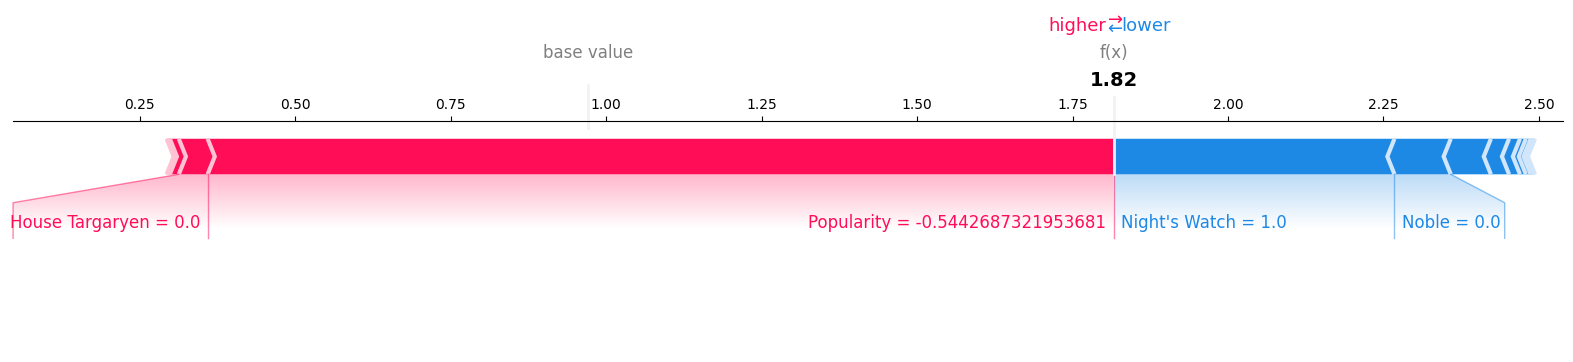

In [16]:
shap.plots.force(explainer.expected_value, shap_values_array[12,:], test.iloc[12, :], matplotlib = True)


In [17]:
y.iloc[25, :]


isAlive    0
Name: 25, dtype: int64

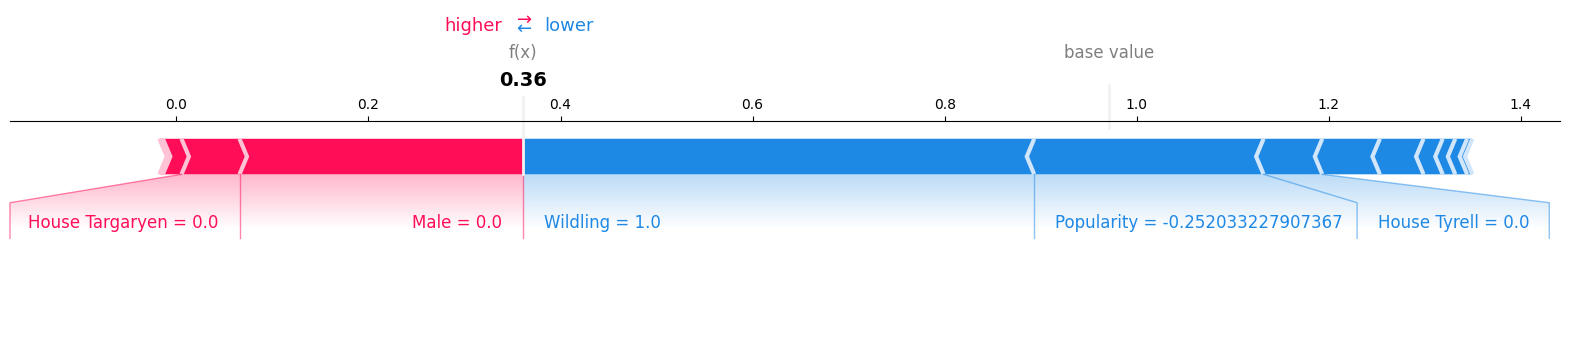

In [18]:
shap.plots.force(explainer.expected_value, shap_values_array[25,:], test.iloc[25, :], matplotlib = True)


isAlive    1
Name: 13, dtype: int64


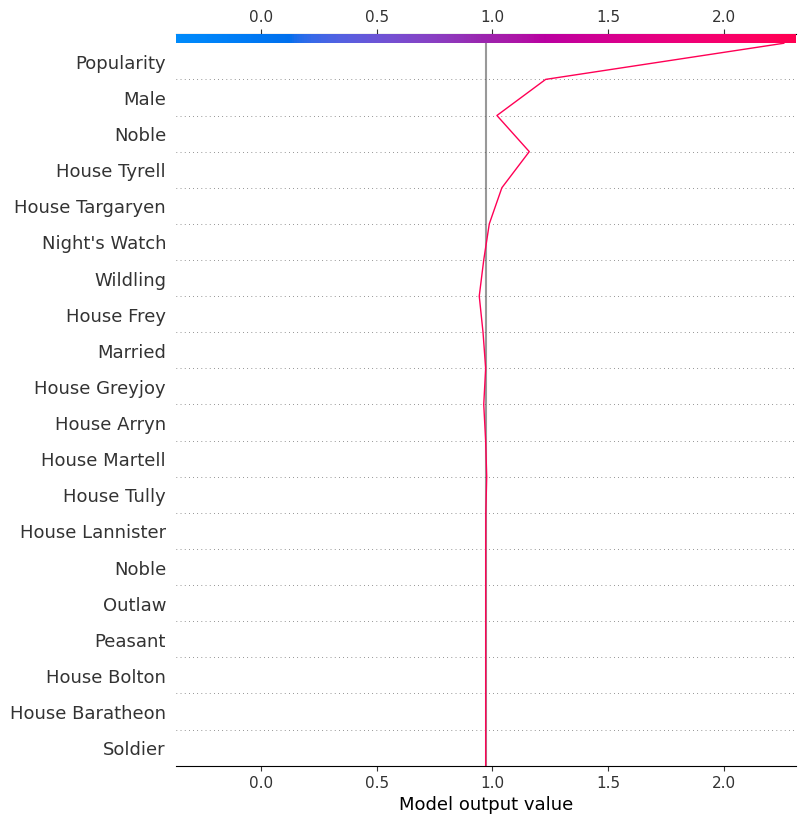

In [19]:
print(y.iloc[13, :])
shap.decision_plot(explainer.expected_value, shap_values_array[13,:], test.columns)


isAlive    0
Name: 3, dtype: int64


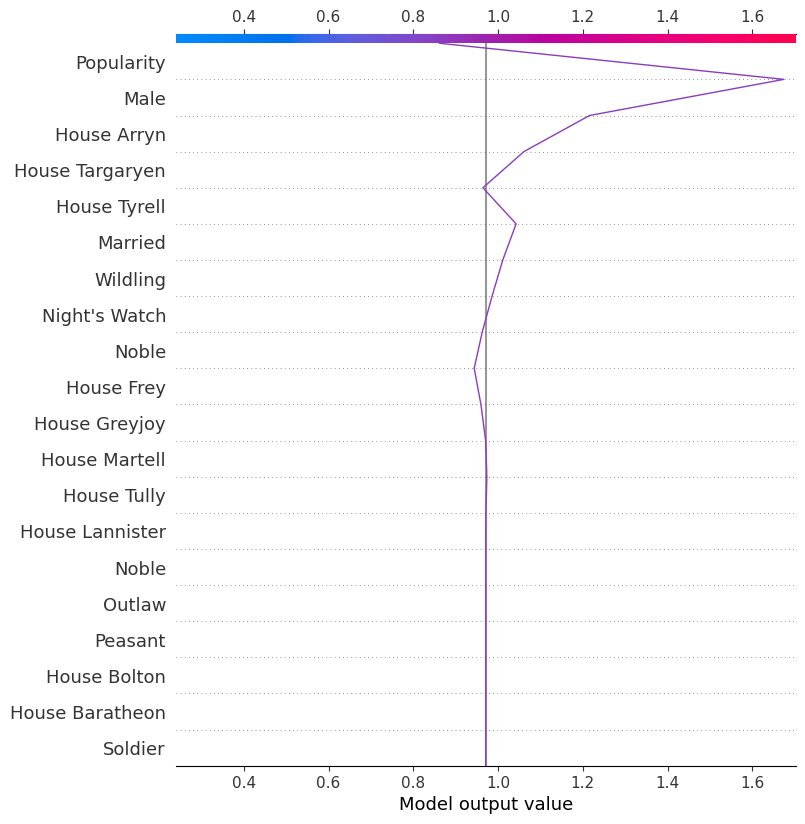

In [20]:
print(y.iloc[3, :])
shap.decision_plot(explainer.expected_value, shap_values_array[3,:], test.columns)


# **Tutorial**: Basic SHAP Interaction Value Example in XGBoost
https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Basic%20SHAP%20Interaction%20Value%20Example%20in%20XGBoost.html

This notebook shows how the SHAP interaction values for a very simple function are computed. We start with a simple linear function, and then add an interaction term to see how it changes the SHAP values and the SHAP interaction values.

## Explain a linear function with no interactions


In [62]:
X_processed = pd.DataFrame(X_processed)


In [63]:
X_processed.columns = ['Popularity', 'Dothraki', 'Foreign Noble',
       'Foreign Peasant', 'House Arryn',
       'House Baratheon', 'House Bolton', 'House Frey',
       'House Greyjoy', 'House Lannister', 'House Martell',
       'House Stark', 'House Targaryen',
       'House Tully', 'House Tyrell', "Night's Watch",
       'Noble', 'Outlaw', 'Peasant', 'Soldier',
       'Wildling', 'Married', 'Noble', 'Male']


In [64]:
pred = model_xgb.predict(X, output_margin=True)


In [65]:
# Calculate SHAP values
X100 = shap.utils.sample(X_processed, 1949) #Before 200
explainer = shap.TreeExplainer(model_xgb["xgbclassifier"],X100)
explanation = explainer(X_processed)
shap_values = explanation.values
# make sure the SHAP values add up to marginal predictions
np.abs(shap_values.sum(axis=1) + explanation.base_values - pred).max()


[22:14:49] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


2.1624521004959263e-06

If we build a beeswarm plot, we see that only features 0 and 1 have any effect on the output, and that their effects only have two possible magnitudes (1/-1 and 1.5/-1.5 correspondingly)

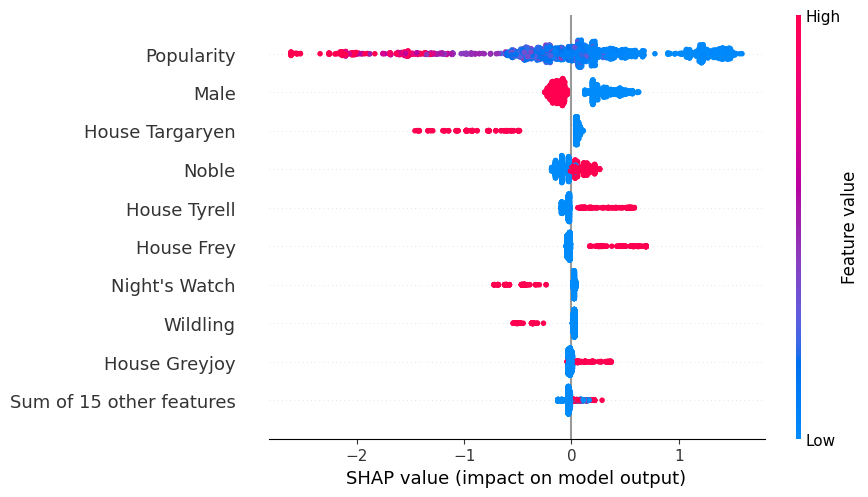

In [66]:
shap.plots.beeswarm(explanation)


Train a linear model

In [71]:
lr = LinearRegression()
lr.fit(X_processed, y)
lr_pred = lr.predict(X_processed)
lr.coef_.round(2)


array([[-0.12, -0.05, -0.02,  0.09,  0.05,  0.01, -0.08,  0.11,  0.09,
        -0.02,  0.04, -0.02, -0.3 , -0.07,  0.11, -0.12,  0.06,  0.03,
         0.09,  0.05, -0.06, -0.01, -0.  , -0.11]])

In [73]:
main_effect_shap_values = lr.coef_ * (X_processed - X_processed.mean(0))
np.linalg.norm(shap_values - main_effect_shap_values)


38.312620641896366

SHAP interaction values

In [74]:
shap_interaction_values = explainer.shap_interaction_values(Xd)
shap_interaction_values[0]


NameError: name 'Xd' is not defined

# Joao's code

In [ ]:
#[x.split("__")[1] for x in model_xgb["columntransformer"].get_feature_names_out()]


In [ ]:
#test = pd.DataFrame(X_processed)
#test.columns = [x.split("__")[1] for x in model_xgb["columntransformer"].get_feature_names_out()]
#shap.summary_plot(shap_values, test)


In [ ]:
#i = 3 #Unpopular Targaryen -> 38
#sample = test.iloc[i:i+1]
#shap_values = explainer(sample)
#print(model_xgb["xgbclassifier"].predict(sample))
#print(sample.loc[i])
#shap.summary_plot(shap_values, sample)


In [21]:
type(test)
test.shape, y.shape


((1949, 24), (1949, 1))

In [22]:
test2 = pd.concat([test, y], axis=1)


In [23]:
print(test2.columns)


Index(['Popularity', 'Dothraki', 'Foreign Noble', 'Foreign Peasant',
       'House Arryn', 'House Baratheon', 'House Bolton', 'House Frey',
       'House Greyjoy', 'House Lannister', 'House Martell', 'House Stark',
       'House Targaryen', 'House Tully', 'House Tyrell', 'Night's Watch',
       'Noble', 'Outlaw', 'Peasant', 'Soldier', 'Wildling', 'Married', 'Noble',
       'Male', 'isAlive'],
      dtype='object')


In [34]:
test2_cols = test2.columns.tolist()
test2_cols


['Popularity',
 'Dothraki',
 'Foreign Noble',
 'Foreign Peasant',
 'House Arryn',
 'House Baratheon',
 'House Bolton',
 'House Frey',
 'House Greyjoy',
 'House Lannister',
 'House Martell',
 'House Stark',
 'House Targaryen',
 'House Tully',
 'House Tyrell',
 "Night's Watch",
 'Noble',
 'Outlaw',
 'Peasant',
 'Soldier',
 'Wildling',
 'Married',
 'Noble',
 'Male',
 'isAlive']

In [28]:
model_xgb["xgbclassifier"]


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.558, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.024, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=6, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [29]:
print(type(model_xgb["xgbclassifier"]))
print(model_xgb["xgbclassifier"])


<class 'xgboost.sklearn.XGBClassifier'>
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.558, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.024, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=6, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)


In [37]:
test2['isAlive'] = test2['isAlive'].astype(float)
print(type(test2))
print(test2.dtypes)


<class 'pandas.core.frame.DataFrame'>
Popularity         float64
Dothraki           float64
Foreign Noble      float64
Foreign Peasant    float64
House Arryn        float64
House Baratheon    float64
House Bolton       float64
House Frey         float64
House Greyjoy      float64
House Lannister    float64
House Martell      float64
House Stark        float64
House Targaryen    float64
House Tully        float64
House Tyrell       float64
Night's Watch      float64
Noble              float64
Outlaw             float64
Peasant            float64
Soldier            float64
Wildling           float64
Married            float64
Noble              float64
Male               float64
isAlive            float64
dtype: object


In [36]:
print(f'columns: {test2.columns}')


columns: Index(['Popularity', 'Dothraki', 'Foreign Noble', 'Foreign Peasant',
       'House Arryn', 'House Baratheon', 'House Bolton', 'House Frey',
       'House Greyjoy', 'House Lannister', 'House Martell', 'House Stark',
       'House Targaryen', 'House Tully', 'House Tyrell', 'Night's Watch',
       'Noble', 'Outlaw', 'Peasant', 'Soldier', 'Wildling', 'Married', 'Noble',
       'Male', 'isAlive'],
      dtype='object')


In [54]:
# Create a simplified DataFrame
simple_df = test2[['Popularity', 'isAlive']].copy()
simple_df['isAlive'] = simple_df['isAlive'].astype(float)

# Try initializing DiCE with this simple DataFrame
d = dice_ml.Data(dataframe=simple_df,
                        continuous_features=['Popularity'],
                        outcome_name='isAlive')


UserConfigValidationException: continuous_features contains some feature names which are not part of columns in dataframe

In [42]:

## Dataset for training an ML model
#d = dice_ml.Data(dataframe=test2,
#                 continuous_features=test2_cols[:-1],
#                 outcome_name='isAlive')
#


In [43]:

# Pre-trained ML model
m = dice_ml.Model(model_xgb["xgbclassifier"], backend='sklearn')
# DiCE explanation instance
exp = dice_ml.Dice(d,m)


In [50]:
i=0


In [53]:
e1 = exp.generate_counterfactuals(simple_df[i:i+1], total_CFs=2, desired_class="opposite")
e1.visualize_as_dataframe(show_only_changes=True)


  0%|          | 0/1 [00:00<?, ?it/s]


ValueError: ('Target', 'isAlive', 'present in query instance')

In [45]:
#e1 = exp.generate_counterfactuals(test[i:i+1], total_CFs=2, desired_class="opposite")
#e1.visualize_as_dataframe(show_only_changes=True)
#


NameError: name 'i' is not defined